WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


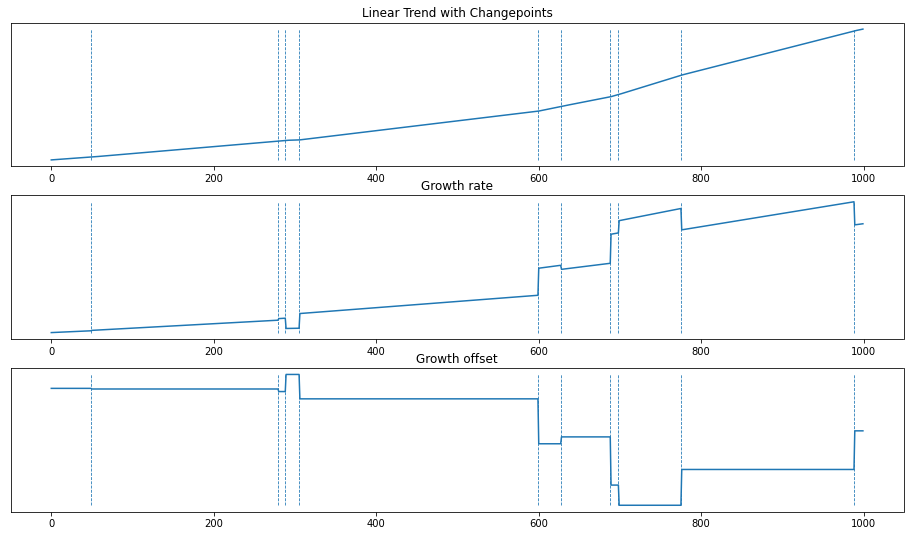

In [5]:
# one shot import all we need for this post
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
# import theano
# import theano.tensor as tt
# from fbprophet import Prophet

np.random.seed(25)
n_changepoints = 10
t = np.arange(1000)
s = np.sort(np.random.choice(t, n_changepoints, replace=False))

A = (t[:, None] > s) * 1
delta = np.random.normal(size=n_changepoints)
k = 1
m = 5

growth = (k + A @ delta) * t
gamma = -s * delta
offset = m + A @ gamma
trend = growth + offset

plt.figure(figsize=(16, 3 * 3))
n = 310
i = 0
for t, f in zip(['Linear Trend with Changepoints', 'Growth rate', 'Growth offset'],
                [trend, growth, offset]):
    i += 1
    plt.subplot(n + i)
    plt.title(t)
    plt.yticks([])
    plt.vlines(s, min(f), max(f), lw=0.8, linestyles='--')
    plt.plot(f)

In [6]:
def det_dot(a, b):
    """
    The theano dot product and NUTS sampler don't work with large matrices?
    
    :param a: (np matrix)
    :param b: (theano vector)
    """
    return (a * b[None, :]).sum(axis=-1)

In [7]:
dic_country = \
{'AUS': 'Australia',
 'BRA': 'Brazil',
 'CAN': 'India',
 'CHN': 'China',
 'GBR': 'United Kingdom',
 'IND': 'India',
 'JPN': 'Japan',
 'SGP': 'Singapore',
 'USA': 'United States'}


datas_m_raw = pd.ExcelFile('../../Data/cleaned/Manufacturing_filled.xlsx')
datas_s_raw = pd.ExcelFile('../../Data/cleaned/Service_filled.xlsx')
datas_m = {}
datas_s = {}
for con in dic_country.keys():
    datas_m[con] = pd.read_excel(datas_m_raw, sheet_name=con)
    datas_s[con] = pd.read_excel(datas_s_raw, sheet_name=con)
pd.DataFrame(dic_country,index=[0]).T.reset_index().rename(columns = {'index': 'country_code', 0: 'country_name'})

,country_code,country_name
0,AUS,Australia
1,BRA,Brazil
2,CAN,India
3,CHN,China
4,GBR,United Kingdom
5,IND,India
6,JPN,Japan
7,SGP,Singapore
8,USA,United States


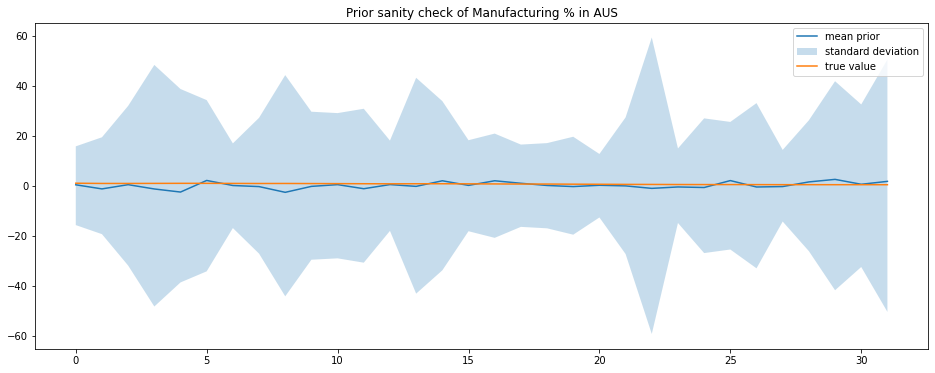

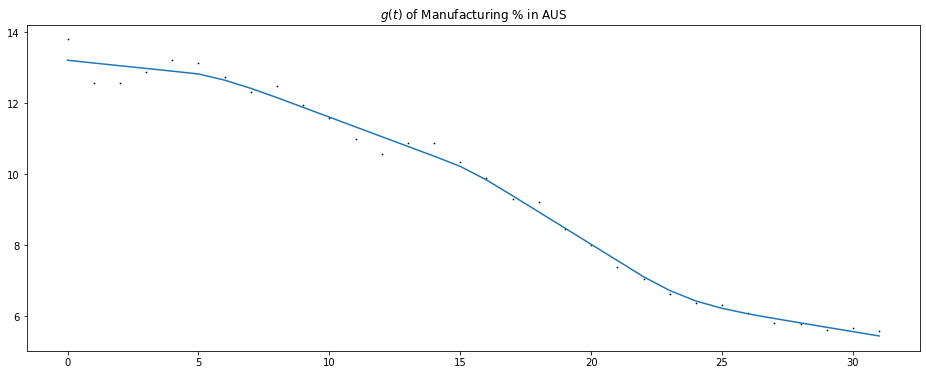

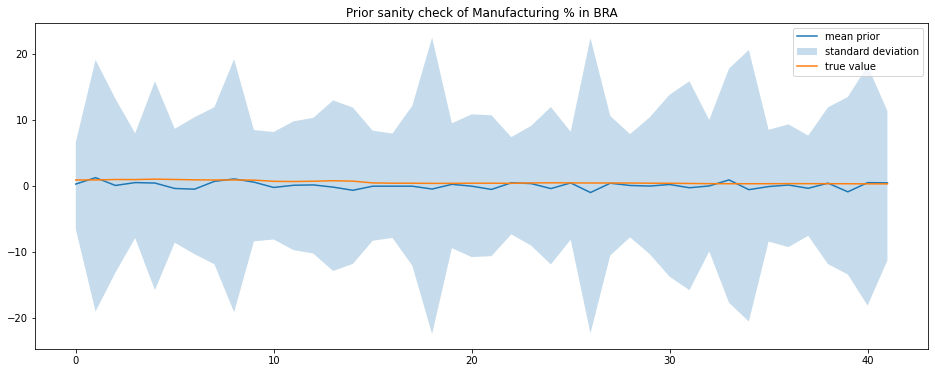

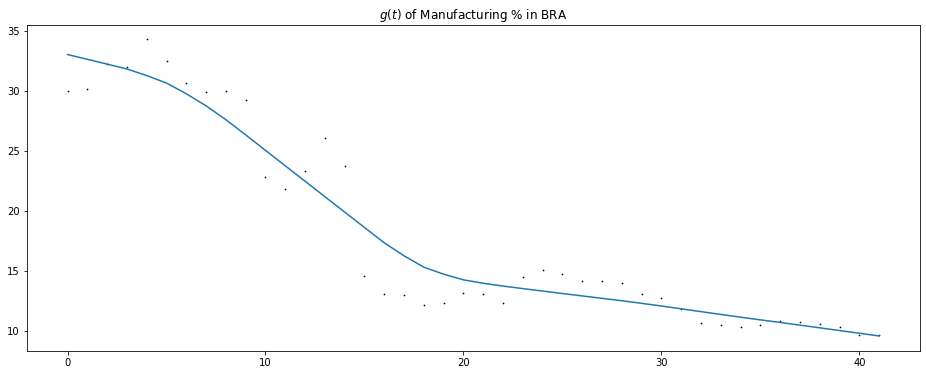

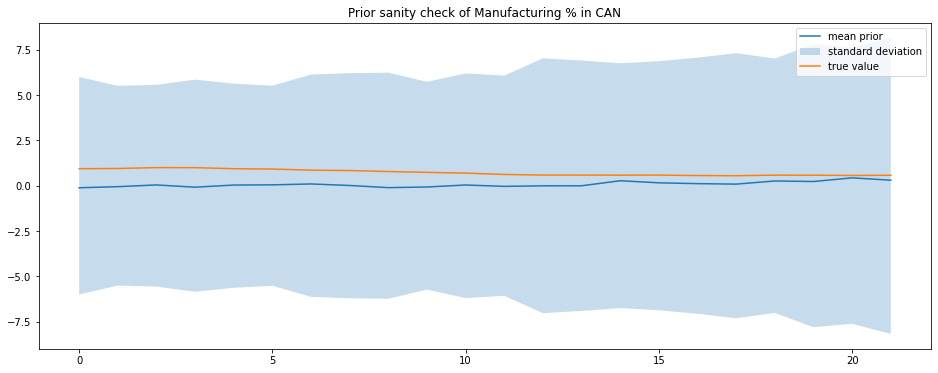

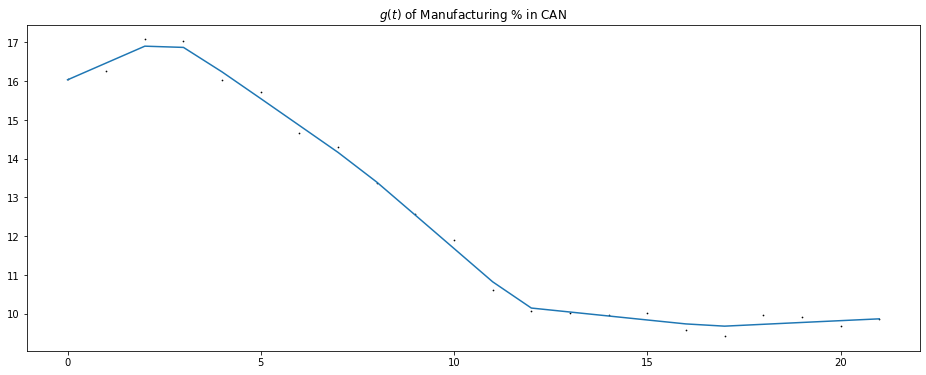

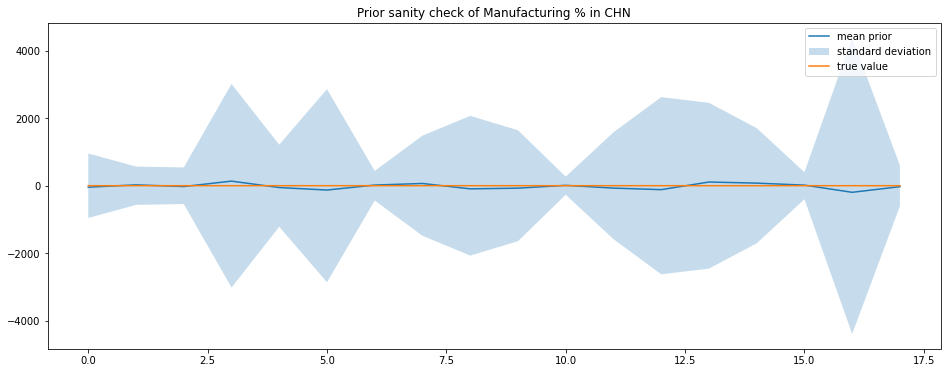

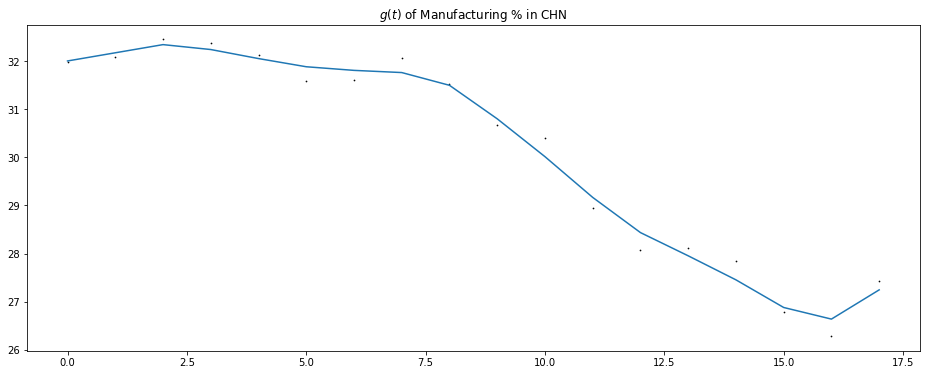

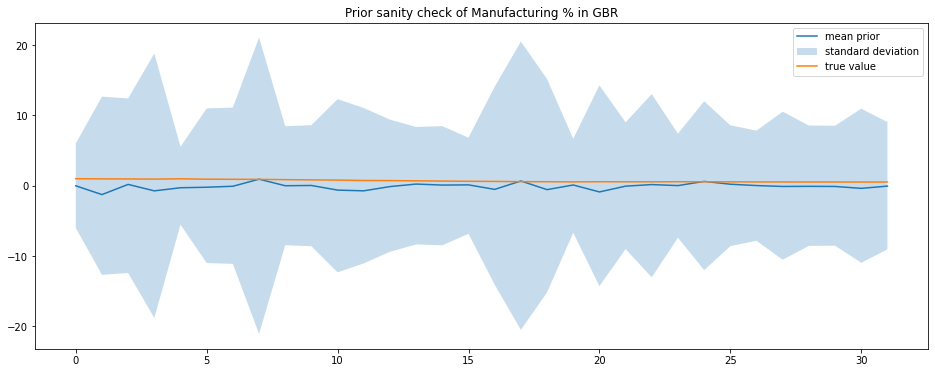

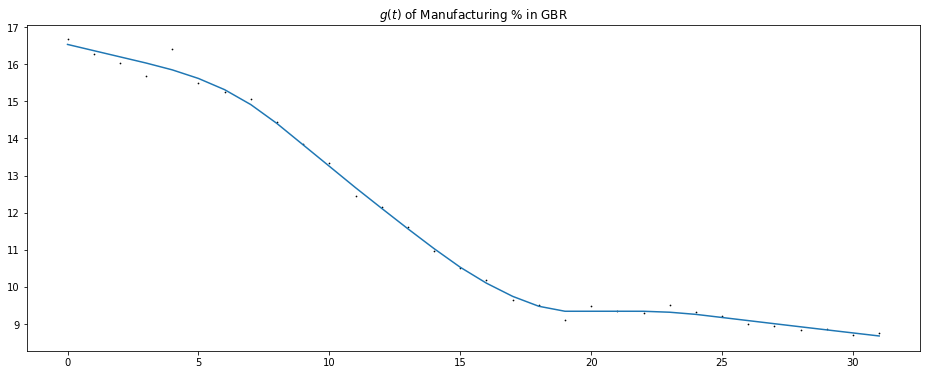

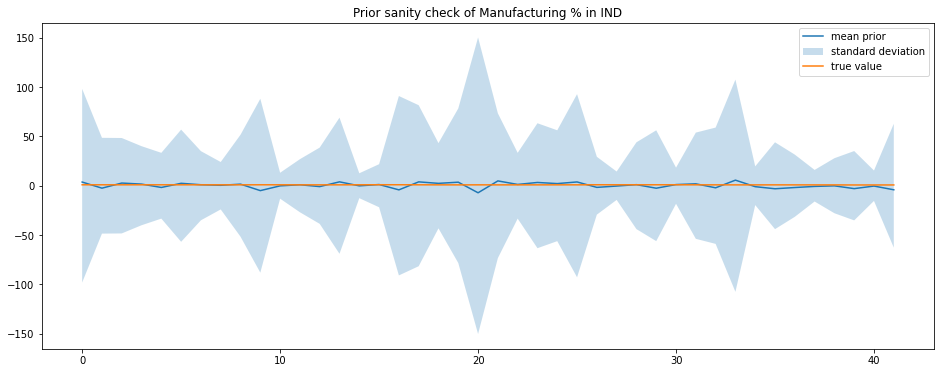

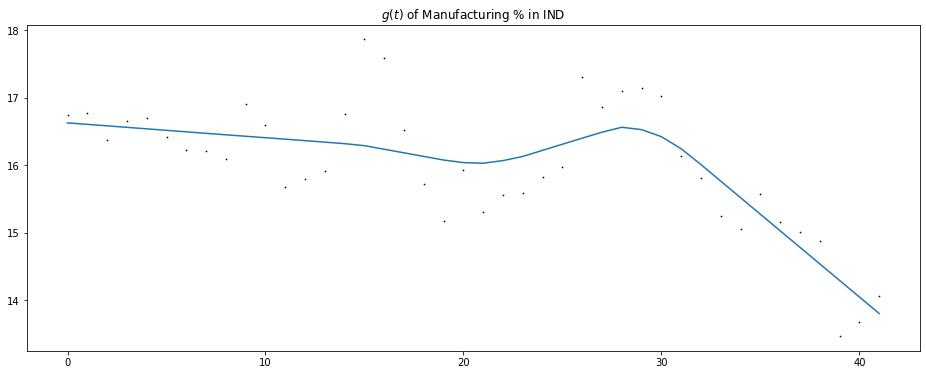

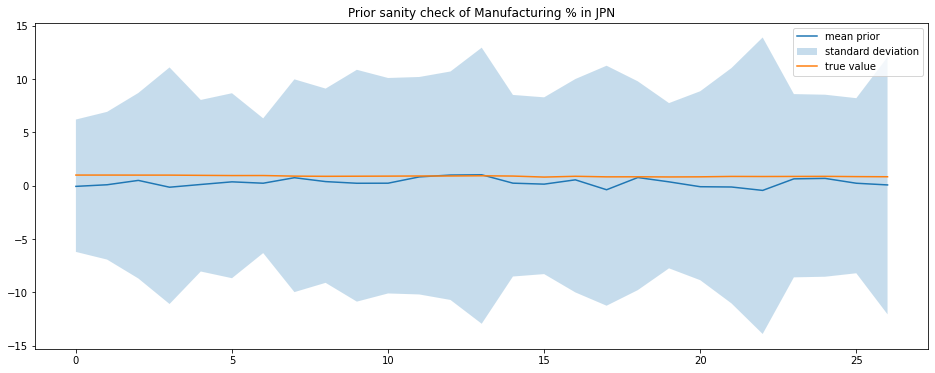

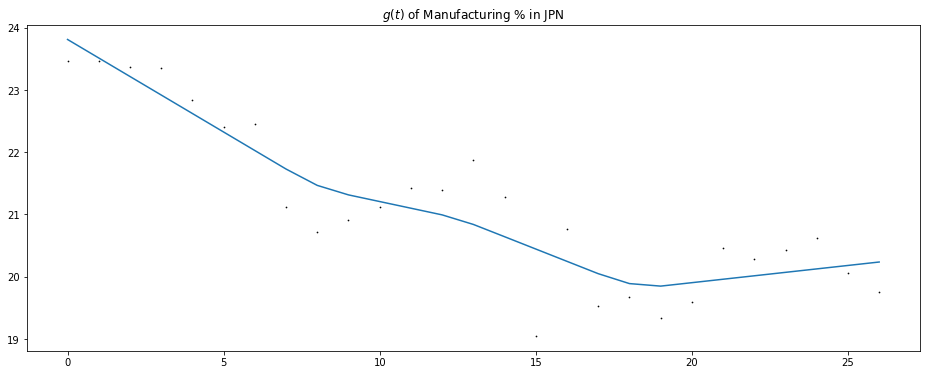

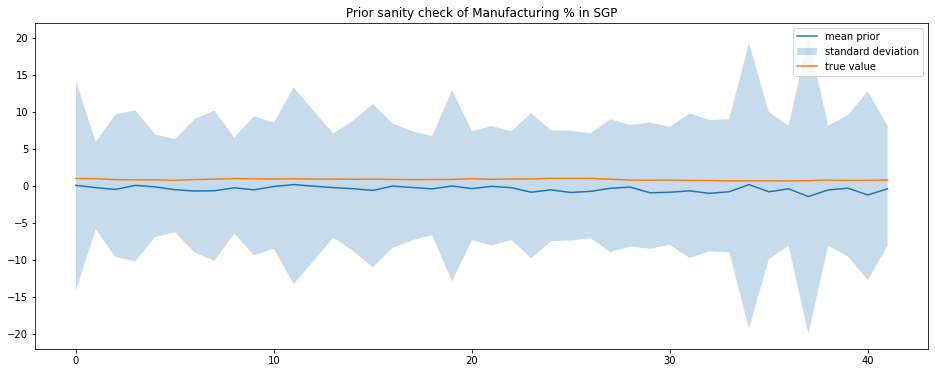

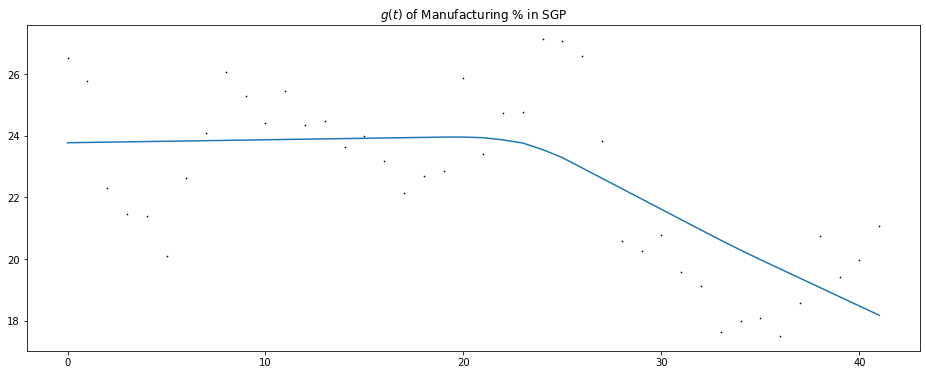

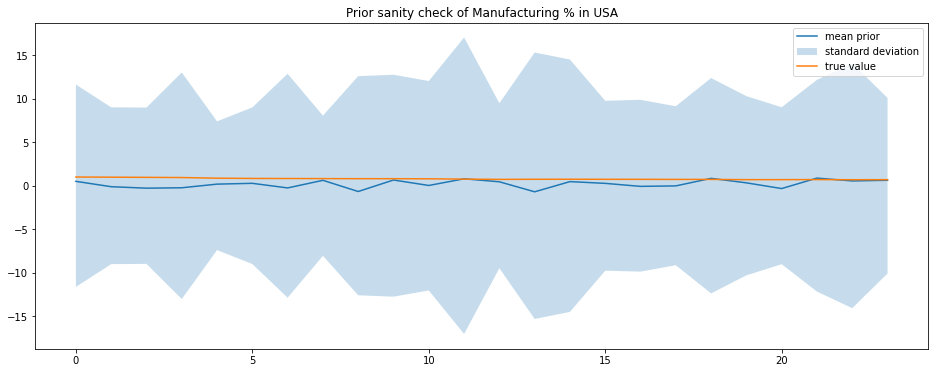

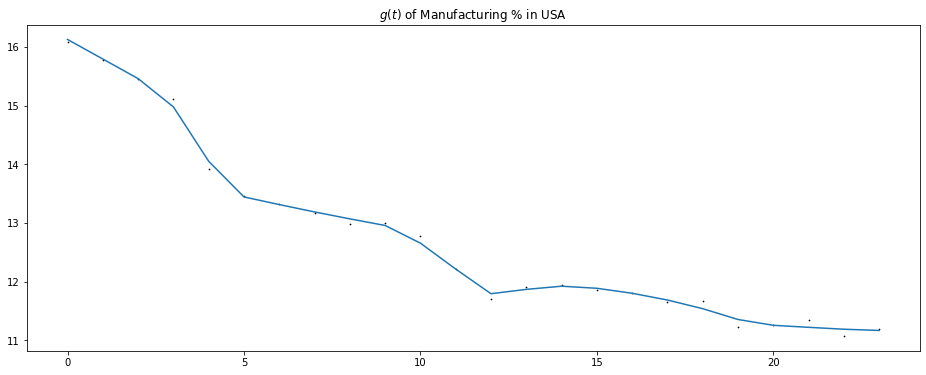

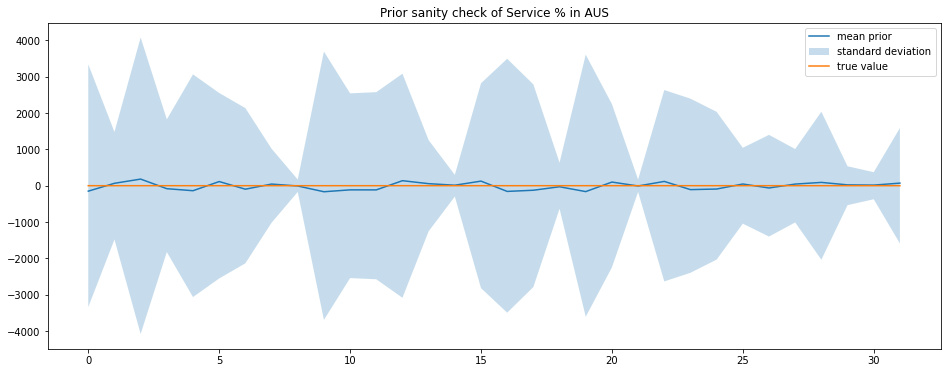

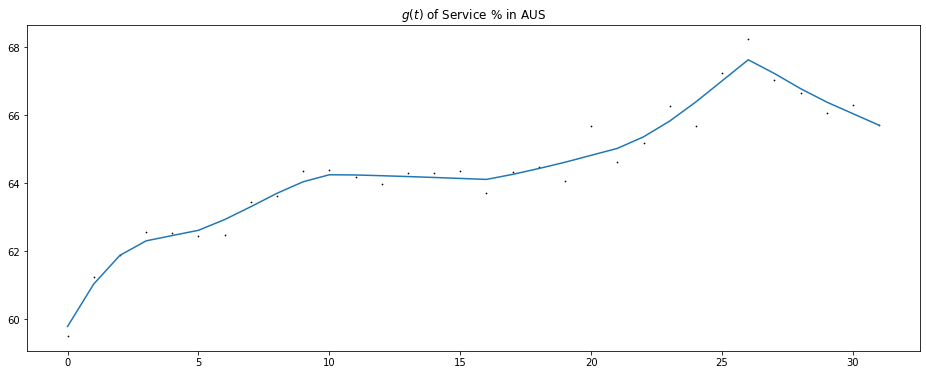

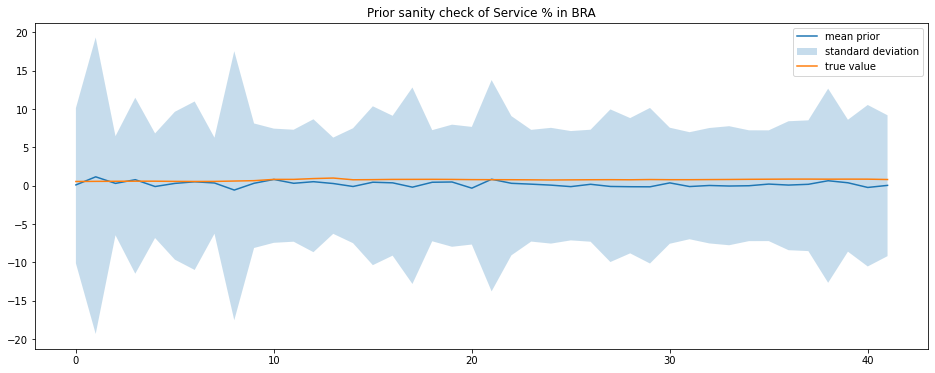

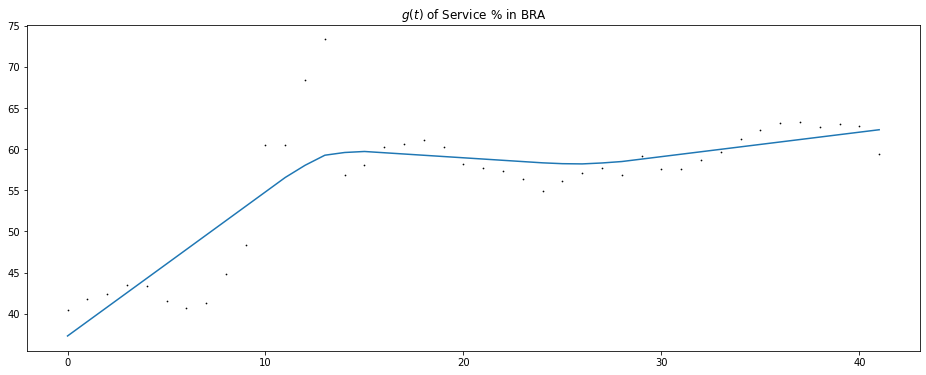

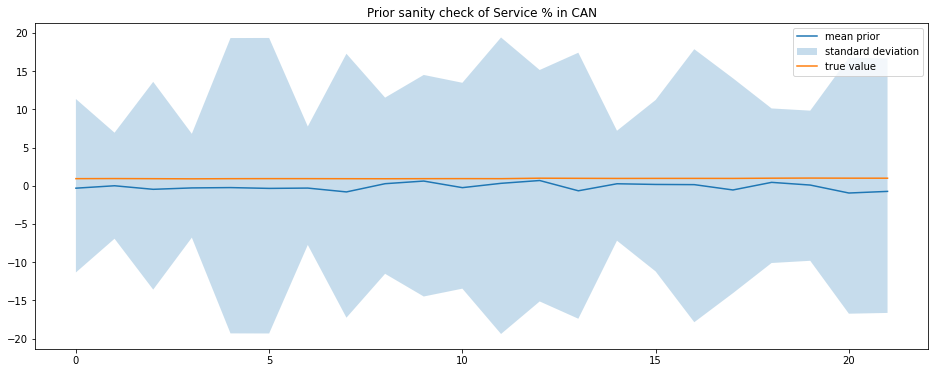

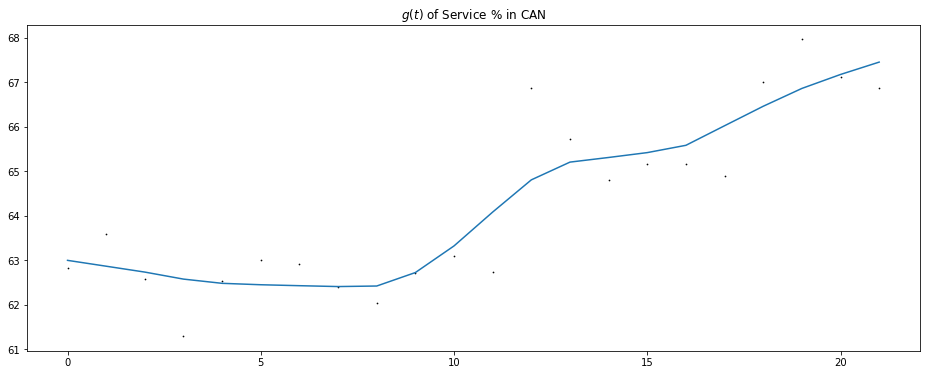

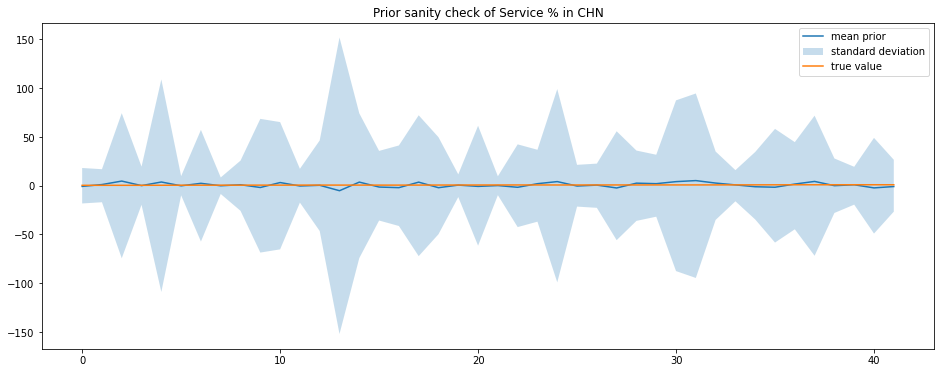

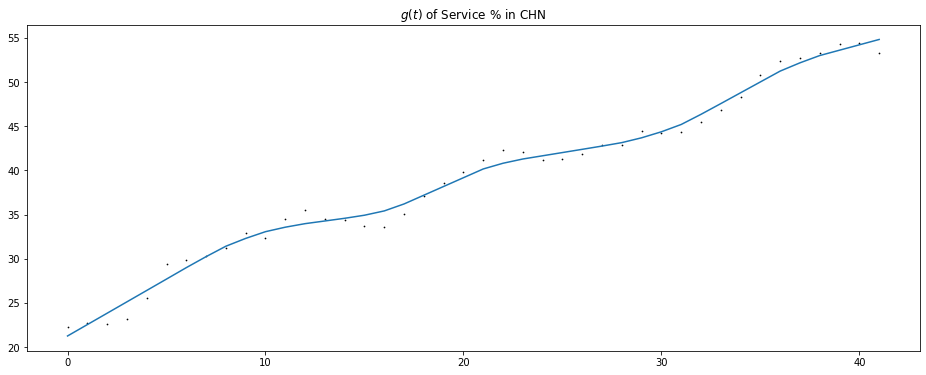

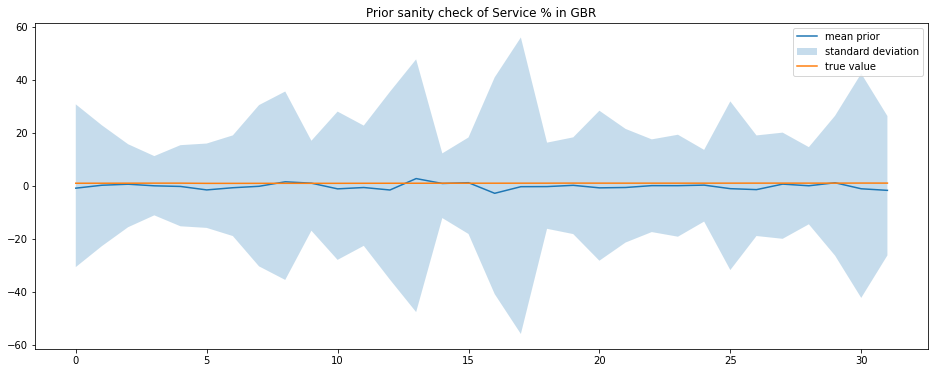

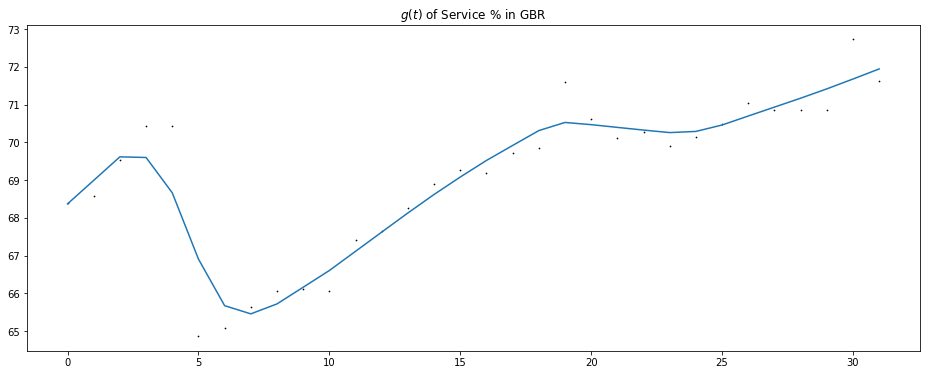

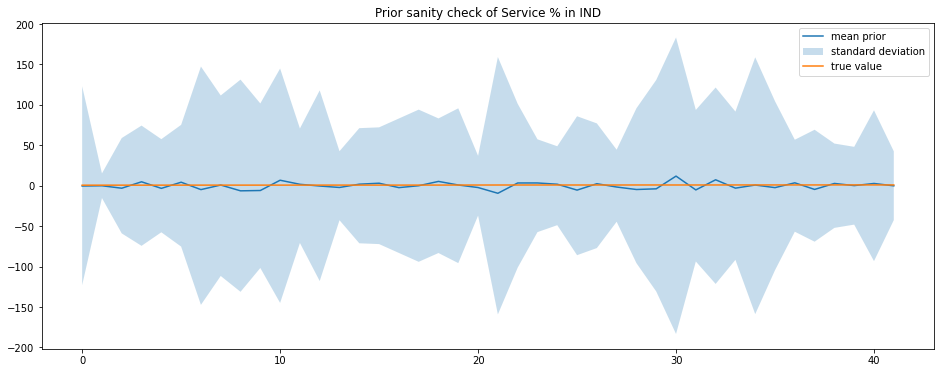

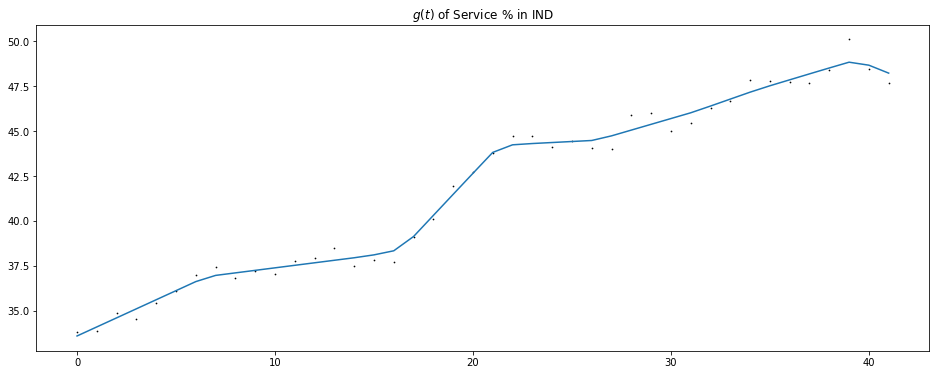

In [8]:
def trend_model(m, t, n_changepoints=25, changepoints_prior_scale=0.2,
                growth_prior_scale=5, changepoint_range=1):
    """
    The piecewise linear trend with changepoint implementation in PyMC3.
    :param m: (pm.Model)
    :param t: (np.array) MinMax scaled time.
    :param n_changepoints: (int) The number of changepoints to model.
    :param changepoint_prior_scale: (flt/ None) The scale of the Laplace prior on the delta vector.
                                    If None, a hierarchical prior is set.
    :param growth_prior_scale: (flt) The standard deviation of the prior on the growth.
    :param changepoint_range: (flt) Proportion of history in which trend changepoints will be estimated. 
    :return g, A, s: (tt.vector, np.array, tt.vector)
    """
    s = np.linspace(0, changepoint_range * np.max(t), n_changepoints + 1)[1:]
    
    # * 1 casts the boolean to integers
    A = (t[:, None] > s) * 1

    with m:
        # initial growth
        k = pm.Normal('k', 0 , growth_prior_scale)
        
        if changepoints_prior_scale is None:
            changepoints_prior_scale = pm.Exponential('tau', 1.5)
        
        # rate of change
        delta = pm.Laplace('delta', 0, changepoints_prior_scale, shape=n_changepoints)
        # offset
        m = pm.Normal('m', 0, 5)
        gamma = -s * delta
        
        g = (k + det_dot(A, delta)) * t + (m + det_dot(A, gamma))
    return g, A, s

def sanity_check(m, df, title):
    """
    :param m: (pm.Model)
    :param df: (pd.DataFrame)
    :param title: (str)
    """
    # Sample from the prior and check of the model is well defined.
    y = pm.sample_prior_predictive(model=m)['obs']
    plt.figure(figsize=(16, 6))
    plt.plot(y.mean(0), label='mean prior')
    plt.fill_between(np.arange(y.shape[1]), -y.std(0), y.std(0), alpha=0.25, label='standard deviation')
    plt.plot(df['y_scaled'], label='true value')
    plt.title(title)
    plt.legend()


for task, y_label, data_contries in [
    ('Manufacturing', "Manufacturing_value added_%_of_GDP", datas_m),                                 
    ('Service', "Services_value_added_%_of_GDP", datas_s)
]:    
    # df = pd.read_csv('example_wp_log_peyton_manning.csv')
    for con in dic_country.keys():
        df = data_contries[con]
        df['y'] = data_contries[con][y_label]
        # Make sure we work with datetime types
        df['ds'] = df['Year']
        # Scale the data
        df['y_scaled'] = df['y'] / df['y'].max()
        df['t'] = (df['ds'] - df['ds'].min()) / (df['ds'].max() - df['ds'].min())
        # df.plot(x='ds', y='y', figsize=(16, 6), title=con)
        # plt.show()


        # Generate a PyMC3 Model context
        m = pm.Model()

        with m:
            y, A, s = trend_model(m, np.array(df['t']))
            
            sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
            pm.Normal('obs', 
                        mu=y,
                        sd=sigma,
                        observed=df['y_scaled'])

        # Run the sanity check
        sanity_check(m, df, title = f'Prior sanity check of {task} % in {con}')

        # x = np.linspace(-10, 10, 1000)
        # pdf = stats.norm.pdf(x, -2, 1) + stats.norm.pdf(x, 5, 0.05) * 0.06
        # mode = pdf.max()
        # mean = pdf.mean()

        # # find the mean of the integrated probablity density function
        # idx_mean = np.argmin(np.abs(np.cumsum(pdf) - np.cumsum(pdf).mean()))
        # idx_mode = pdf.argmax()
        # plt.figure(figsize=(16, 6))
        # plt.plot(x, pdf)
        # plt.vlines([x[idx_mean], x[idx_mode]], 0, mode, lw=0.8, linestyles='--')
        # plt.annotate('mean', (x[idx_mean] + 0.2, mode * 0.9))
        # plt.annotate('mode', (x[idx_mode] + 0.2, mode * 0.9))

        # Find a point estimate of the models parameters
        with m:
            aprox = pm.find_MAP()

        # Determine g, based on the parameters
        def det_trend(k, m, delta, t, s, A):
            return (k + np.dot(A, delta)) * t + (m + np.dot(A, (-s * delta)))

        # run function and rescale to original scale
        g = det_trend(aprox['k'], aprox['m'], aprox['delta'], df['t'], s, A) * df['y'].max()

        plt.figure(figsize=(16, 6))
        plt.title(f'$g(t)$ of {task} % in {con}')
        plt.plot(g)
        plt.scatter(np.arange(df.shape[0]), df.y, s=0.5, color='black')
        plt.show()